In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier


# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200


In [3]:
#Combine original modeling data with additionally scraped data
df_1 = pd.read_csv('../data/modeling_df.csv') # still contains separate title and body columns
df_2 = pd.read_csv('../data/additional_data.csv') # title and body combined to text column


In [4]:
df_1.isnull().sum()
df_1.fillna(" ", inplace = True)


In [5]:
df_1.isnull().sum()


title                     0
body                      0
subreddit                 0
body_word_count           0
body_character_length     0
title_character_length    0
title_upper_case_ratio    0
dtype: int64

In [6]:
df_1['text'] = df_1['title'] + " " + df_1['body']
df_1.drop(columns = {'title', 'body'}, inplace = True)


In [7]:
df_1.reset_index(drop = True, inplace = True)
df_2.reset_index(drop = True, inplace = True)


In [8]:
df = pd.concat([df_1, df_2], axis = 0)


In [9]:
df.isnull().sum()


subreddit                 0
body_word_count           0
body_character_length     0
title_character_length    0
title_upper_case_ratio    0
text                      0
dtype: int64

In [10]:
df.head()


,subreddit,body_word_count,body_character_length,title_character_length,title_upper_case_ratio,text
0,1,211,1268,128,0.054688,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the 2020 presidential race aft...
1,1,159,1039,108,0.064815,cmv kanye west is a shill for president trump and running to syphon off young voters from voting for biden kanye west is a shill for president trump and running to syphon off young voters from vot...
2,1,322,1852,104,0.076923,cmv donald trump has not made a single lasting positive impact on the usa during his term as president i write this because i am tired of the wild goose chase that is finding examples of his succe...
3,1,108,686,100,0.090000,cmv politicians should be required to wear nascarstyle jumpsuits showing all their major sponsors in recent days some have decried the potus and fdotus brazenly ignoring federal ethics laws by pos...
4,1,393,2317,150,0.046667,cmv us presidential candidates should take an exam covering us government and law foreign policy as well as undergo a comprehensive cognitive exam edit ok this has been fun and some great conversa...


In [11]:
df['text'] = df['text'].astype(str)
df['text'] = df['text'].str.replace('\d+', '')


In [12]:
corpus = list(df['text'])
corpus


['cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the  presidential race after spending over  million dollars of his own money on his campaign even with this loss he is still worth over  billion dollars\n believe that this effortless spending on bloombergs part showcases the reality that is wealth inequality between the ultra rich and working class while i do not believe the rich should give up their fortunes i do believe that any arguments against taxing them more is simply propaganda from those who hold the wealth and higher power at this point  media outlets claim that taxing the super wealthy is unfair and would be detrimental to those below them due to trickle down effects there is also rhetoric that many self made billionaires worked hard for their fortunes and that if we as americans work hard we might be rich ourselves one day believe that moving forward we shou

In [13]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()
#Get polarity scores for the first tweet
sia.polarity_scores(corpus[0])


{'neg': 0.075, 'neu': 0.795, 'pos': 0.13, 'compound': 0.9532}

In [14]:
#create dataframe that contains text and the polarity scores for each tweet

dicts = []    

for tweet in corpus:
    scores = sia.polarity_scores(tweet)
    scores['text'] = tweet
    dicts.append(scores)

df_VADER = pd.DataFrame(dicts)
df_VADER.head()

,neg,neu,pos,compound,text
0,0.075,0.795,0.130,0.9532,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the presidential race after s...
1,0.017,0.839,0.144,0.9732,cmv kanye west is a shill for president trump and running to syphon off young voters from voting for biden kanye west is a shill for president trump and running to syphon off young voters from vot...
2,0.063,0.765,0.172,0.9917,cmv donald trump has not made a single lasting positive impact on the usa during his term as president i write this because i am tired of the wild goose chase that is finding examples of his succe...
3,0.039,0.829,0.132,0.8280,cmv politicians should be required to wear nascarstyle jumpsuits showing all their major sponsors in recent days some have decried the potus and fdotus brazenly ignoring federal ethics laws by pos...
4,0.085,0.766,0.149,0.9689,cmv us presidential candidates should take an exam covering us government and law foreign policy as well as undergo a comprehensive cognitive exam edit ok this has been fun and some great conversa...


In [15]:
df_VADER.shape

(2517, 5)

In [16]:
#Merge numerical features from df with VADER
#num_feat = df.drop(columns = {'subreddit'})
df = pd.merge(df_VADER, df, on = 'text', right_index=True)
df.head()

,neg,neu,pos,compound,text,subreddit,body_word_count,body_character_length,title_character_length,title_upper_case_ratio
0,0.075,0.795,0.130,0.9532,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the presidential race after s...,1,211,1268,128,0.054688
1,0.017,0.839,0.144,0.9732,cmv kanye west is a shill for president trump and running to syphon off young voters from voting for biden kanye west is a shill for president trump and running to syphon off young voters from vot...,1,159,1039,108,0.064815
2,0.063,0.765,0.172,0.9917,cmv donald trump has not made a single lasting positive impact on the usa during his term as president i write this because i am tired of the wild goose chase that is finding examples of his succe...,1,322,1852,104,0.076923
3,0.039,0.829,0.132,0.8280,cmv politicians should be required to wear nascarstyle jumpsuits showing all their major sponsors in recent days some have decried the potus and fdotus brazenly ignoring federal ethics laws by pos...,1,108,686,100,0.090000
4,0.085,0.766,0.149,0.9689,cmv us presidential candidates should take an exam covering us government and law foreign policy as well as undergo a comprehensive cognitive exam edit ok this has been fun and some great conversa...,1,393,2317,150,0.046667


In [17]:
df.shape

(2519, 10)

In [18]:
df['target'] = df['subreddit'].values
df.head(5)


,neg,neu,pos,compound,text,subreddit,body_word_count,body_character_length,title_character_length,title_upper_case_ratio,target
0,0.075,0.795,0.130,0.9532,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the presidential race after s...,1,211,1268,128,0.054688,1
1,0.017,0.839,0.144,0.9732,cmv kanye west is a shill for president trump and running to syphon off young voters from voting for biden kanye west is a shill for president trump and running to syphon off young voters from vot...,1,159,1039,108,0.064815,1
2,0.063,0.765,0.172,0.9917,cmv donald trump has not made a single lasting positive impact on the usa during his term as president i write this because i am tired of the wild goose chase that is finding examples of his succe...,1,322,1852,104,0.076923,1
3,0.039,0.829,0.132,0.8280,cmv politicians should be required to wear nascarstyle jumpsuits showing all their major sponsors in recent days some have decried the potus and fdotus brazenly ignoring federal ethics laws by pos...,1,108,686,100,0.090000,1
4,0.085,0.766,0.149,0.9689,cmv us presidential candidates should take an exam covering us government and law foreign policy as well as undergo a comprehensive cognitive exam edit ok this has been fun and some great conversa...,1,393,2317,150,0.046667,1


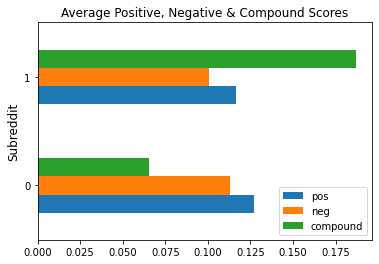

In [20]:
df.groupby('target').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores', fontsize = 12)
plt.ylabel('Subreddit', fontsize = 12);


In [19]:
# Note: This dataset is 57% from 0 class (UO), 42 % from 1 class (CMV)


In [20]:
X = df[['text', 'pos', 'neg', 'neu', 'compound',
        'body_word_count', 'body_character_length',
        'title_character_length', 'title_upper_case_ratio']] # text & numeric data

y = df['target'] 


In [21]:
y.value_counts(normalize = True)


0    0.577213
1    0.422787
Name: target, dtype: float64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 39, stratify = y)


In [23]:
# Baseline accuracy for training and test sets
y_train.mean(), y_test.mean()


(0.422575155984118, 0.42328042328042326)

In [24]:
y_train.value_counts()

0    1018
1     745
Name: target, dtype: int64

In [25]:
y_test.value_counts()

0    436
1    320
Name: target, dtype: int64

In [26]:
# Sklearn stopwords + 'cmv' & 'changemyview'
custom = ['cmv', 'changemyview', 'change', 'view', 'unpopular', 'opinion'] # my is in list of english stopwords
english_plus = text.ENGLISH_STOP_WORDS.union(custom) # English stopwords + my custom stopwords


In [27]:
# countvectorize JUST the text data and create new dataframes
#cv = CountVectorizer(stop_words = english_plus, max_features = 3000)                       

tvec = TfidfVectorizer(stop_words = english_plus,
                       max_df = 0.9,
                       min_df = 10,
                       ngram_range = (1,1)) 

X_train_tvec = tvec.fit_transform(X_train['text'])
X_test_tvec = tvec.transform(X_test['text'])


In [28]:
df_X_train = pd.DataFrame(X_train_tvec.todense(), columns=tvec.get_feature_names())
df_X_test = pd.DataFrame(X_test_tvec.todense(), columns =tvec.get_feature_names())

df_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)


In [29]:
combined_X_train = pd.concat([df_X_train, X_train], axis = 1)
combined_X_train.head()


,ability,able,abortion,absolute,absolutely,absurd,abuse,abused,abusive,academic,...,zero,text,pos,neg,neu,compound,body_word_count,body_character_length,title_character_length,title_upper_case_ratio
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,sexual assault against men is treated as comedy in television one example that made me think of this are from the office such as when michael and jan are in the bathroom at a party and jan is forc...,0.135,0.076,0.788,0.7351,98,501,62,0.016129
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,critical role gets too much credit for the resurgence of dd they rode the wave of e they by no means made it critical role definitely helped dd get on more peoples radar but dd was getting exponen...,0.228,0.043,0.729,0.9731,78,419,113,0.053097
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,the women who say most men are trash go for trash men now this isnt about anyone who was assaulted by many men this is for those that brought their own pain\n that say this usually love the bad bo...,0.122,0.172,0.706,-0.7684,131,698,55,0.018182
3,0.0,0.0,0.0,0.300951,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,sus is one of the dumbest new overused words i have ever heard that among us game has really made everyone feel cool saying sus all the time thats so sus bro im not exactly sure why but it sounds ...,0.027,0.197,0.776,-0.8826,40,206,66,0.030303
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,the vast majority of people are only supportive about your mental illness until you exhibit symptoms this is so common and i never see anyone talk about it people love to claim that they will supp...,0.091,0.252,0.656,-0.9957,239,1353,100,0.010000


In [30]:
combined_X_test = pd.concat([df_X_test, X_test], axis =1)
combined_X_test.head()


,ability,able,abortion,absolute,absolutely,absurd,abuse,abused,abusive,academic,...,zero,text,pos,neg,neu,compound,body_word_count,body_character_length,title_character_length,title_upper_case_ratio
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,people need to stop generalizing america as a place where everyone shoots guns eats fast food all day and is a total redneck america is a great country and it’s very diverse you don’t run into the...,0.064,0.063,0.873,-0.2292,93,551,127,0.015748
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,missionary position is the best position nsfw missionary position is the best position you get to see all the facial expressions it’s easy to kissmake out during sex you get to make good eye conta...,0.230,0.022,0.748,0.9737,90,511,48,0.104167
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,family is a term no organization should use to describe their groups i personally hate it when i hear the term were a family from corporate idiots and even within other organizations it professio...,0.000,0.134,0.866,-0.7096,34,194,71,0.014085
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.077022,0.0,0.0,0.0,...,0.0,the sex offender registry should only be for people for individuals who pose a risk to the safety of others not some year old who sent a dick pic okay i just got down watching a reddit video arou...,0.090,0.179,0.731,-0.9733,259,1426,150,0.013333
4,0.0,0.0,0.268414,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,cmv even if we assume the life begins at conception the government should not ban abortions so i know i know there are way to many abortion cmvs here but i am curious about looking at it from a pa...,0.134,0.082,0.784,0.9475,265,1458,93,0.043011


In [31]:
combined_X_train.drop(columns = 'text', inplace=True)
combined_X_test.drop(columns = 'text', inplace = True)


## Logistic Regression

In [32]:
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())    
])


In [33]:
pipe_lr_params = {'ss__with_mean': [True, False],
                  'ss__with_std' : [True, False],
                  'lr__penalty' : ['l2'],                       
                  'lr__C' :[1, 0.1, 0.001, 10],
                  'lr__solver': ['lbfgs', 'newton-cg'],
                  'lr__max_iter': [2000, 3000, 5000]
                 
                 }

In [34]:
pipe_lr_gridsearch = GridSearchCV(pipe_lr, 
                                 pipe_lr_params, 
                                 cv = 5, 
                                 verbose=1)


In [35]:
pipe_lr_gridsearch.fit(combined_X_train, y_train)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 11.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1, 0.1, 0.001, 10],
                         'lr__max_iter': [2000, 3000, 5000],
                         'lr__penalty': ['l2'],
                         'lr__solver': ['lbfgs', 'newton-cg'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [36]:
pipe_lr_gridsearch.best_score_


0.8581879345866599

In [37]:
pipe_lr_gridsearch.best_params_

{'lr__C': 10,
 'lr__max_iter': 2000,
 'lr__penalty': 'l2',
 'lr__solver': 'lbfgs',
 'ss__with_mean': True,
 'ss__with_std': False}

In [38]:
pipe_lr_gridsearch.score(combined_X_test, y_test)


0.8531746031746031

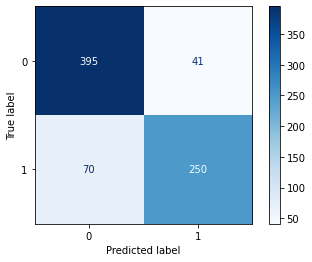

In [39]:
# Get predictions
preds = pipe_lr_gridsearch.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(pipe_lr_gridsearch, combined_X_test, y_test, cmap='Blues', values_format='d');


In [40]:
# Calculate the specificity
tn / (tn + fp)


0.9059633027522935

In [41]:
# Predicted Probabilities
pred_proba = pipe_lr_gridsearch.predict_proba(combined_X_test)[:,1]

In [42]:
def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Unpopular Opinion', 'Change My View'], 
                            columns=['Predicted Unpopular Opinion', 'Predicted Change My View']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))

In [43]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.8531746031746031  

----------------------------------------------------------------
                   Predicted Unpopular Opinion  Predicted Change My View
Unpopular Opinion                          395                        41
Change My View                              70                       250 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       436
           1       0.86      0.78      0.82       320

    accuracy                           0.85       756
   macro avg       0.85      0.84      0.85       756
weighted avg       0.85      0.85      0.85       756

-----------------------------------------------------------------
ROC_AUC SCORE 0.9310636467889908 


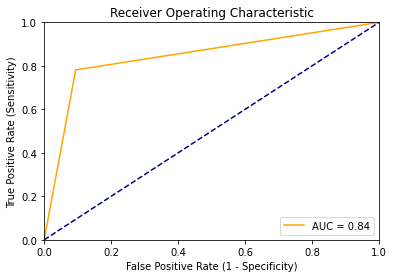

In [44]:
#ROC/AUC Curve
from sklearn import metrics
pred_proba
preds 
fp, tp, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fp, tp)


plt.title('Receiver Operating Characteristic')
plt.plot(fp, tp, 'b', label = 'AUC = %0.2f' % roc_auc, color = 'orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color = 'navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

## RandomForests

In [45]:
rf = RandomForestClassifier()
cross_val_score(rf, combined_X_train, y_train).mean()

0.8842679629152717

In [46]:
params = {
    'n_estimators': [150, 175, 200],
    'max_depth' : [None, 3, 4],
    'max_features': ['auto', None]
    
}
gs = GridSearchCV(rf, param_grid = params)
gs.fit(combined_X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 4],
                         'max_features': ['auto', None],
                         'n_estimators': [150, 175, 200]})

In [47]:
gs.best_score_


0.9171919263456092

In [48]:
gs.best_params_


{'max_depth': None, 'max_features': None, 'n_estimators': 200}

In [49]:
gs.score(combined_X_test, y_test)


0.9285714285714286

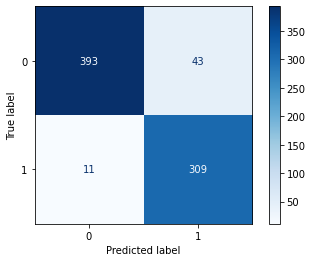

In [50]:
# Get predictions
preds = gs.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, combined_X_test, y_test, cmap='Blues', values_format='d');


In [51]:
# Calculate the specificity
tn / (tn + fp)


0.9013761467889908

In [52]:
# Predicted Probabilities
pred_proba = gs.predict_proba(combined_X_test)[:,1]

In [53]:
def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Unpopular Opinion', 'Change My View'], 
                            columns=['Predicted Unpopular Opinion', 'Predicted Change My View']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))
    

In [54]:
metrics(y_test, preds, pred_proba)


Accuracy score 0.9285714285714286  

----------------------------------------------------------------
                   Predicted Unpopular Opinion  Predicted Change My View
Unpopular Opinion                          393                        43
Change My View                              11                       309 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       436
           1       0.88      0.97      0.92       320

    accuracy                           0.93       756
   macro avg       0.93      0.93      0.93       756
weighted avg       0.93      0.93      0.93       756

-----------------------------------------------------------------
ROC_AUC SCORE 0.9680225057339449 


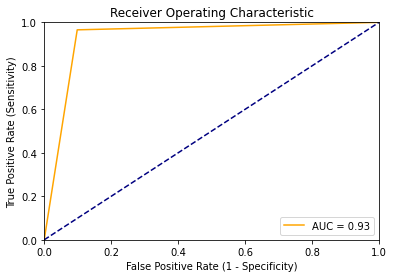

In [55]:
#ROC/AUC Curve
from sklearn import metrics
pred_proba
preds 
fp, tp, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fp, tp)


plt.title('Receiver Operating Characteristic')
plt.plot(fp, tp, 'b', label = 'AUC = %0.2f' % roc_auc, color = 'orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color = 'navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()